In [1]:
%load_ext autoreload
%autoreload 2 
from vpot.calc import myMolecule
from vpot.calc.grids import sphericalGrid, blockGrid, pointGrid,sphericalAtomicGrid,blockAtomicGrid,sphericalIndexGrid
from vpot.calc.potential import vpot,vBpot, vpotANC
from vpot.calc import DFTGroundState
from matplotlib import pyplot as plt
from scipy.special import erf
from scipy.optimize import minimize
from vpot.calc.grids import sphericalAtomicGrid
from psi4.driver import qcdb
from ase.data import atomic_numbers


import psi4
import numpy as np
import logging,time

plt.style.use("dark_background")

   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 2   entry CL         line   534 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 


Basis is augmented!

Basis set has 116 functions
   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 2   entry CL         line   534 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 


Basis is augmented!

Basis set has 92 functions
Creating a spherical grid for Index 0
   => Loading Basis Set <=

    Name: DEF2-TZVP
 

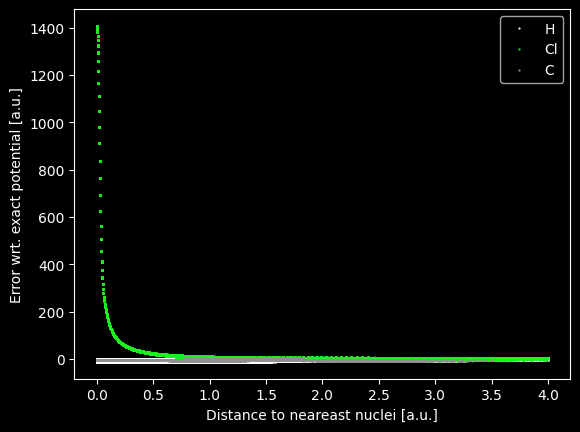

(-300.0, 100.0)

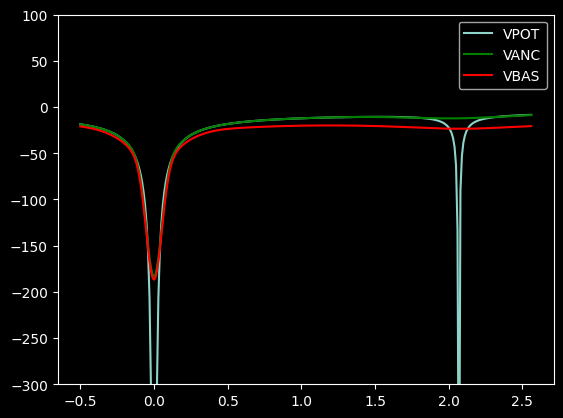

In [4]:
nSphere = 590
nRadial = 300
prec=2

Vs = [] 

for atomIdx in [0,1,2,3,4]:
    M = myMolecule("tests/CH3Cl.xyz","def2-TZVP",labelAtoms=True)
    M.keepAugmentBasisForIndex(atomIdx)

    
    a,newOrb = qcdb.BasisSet.pyconstruct(M.psi4Mol.to_dict(),'BASIS',
                                                "def2-TZVP",fitrole='ORBITAL',
                                                other=None,return_dict=True,return_atomlist=False)
    for i in newOrb["shell_map"]:
        del i[2:]

    for c,i in enumerate(M.getOrbitalDict()["shell_map"]):
        if c == atomIdx:
            newOrb["shell_map"][c] += i[2:]
    
    
    M.setBasisDict(orbitalDict=newOrb,augmentDict=M.getAugmentDict(),quiet=True)
    
    if atomIdx in [2,3,4]:
        Gb =  sphericalIndexGrid(M,atomIdx,minDist=0.0,maxDist=0.5,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
    elif atomIdx in [0,1]:
        Gb =  sphericalIndexGrid(M,atomIdx,minDist=0.0,maxDist=1.5,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
    Vs.append(Gb.optimizeBasis(potentialType="anc",a=2))
    
M = myMolecule("tests/CH3Cl.xyz","def2-TZVP")
Gb =  sphericalGrid(M,minDist=0.0,maxDist=4.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
Vb = Gb.optimizeBasis(potentialType="anc",a=2)

for c,i in enumerate(Vb.diagonal()):
    Vb[c][c] = 0.0 
  
counter = 0
for c2,j in enumerate(Vs):
    for c,i in enumerate(j.diagonal()):
        if c2 in [0,2]:
            Vb[counter][counter] = i
        counter+=1


Gb.printStats(Vb,output="print")
Gb.exportErrorVsDistance(Vb)

P1 = M.geom[0]
P2 = M.geom[2]

v = P2-P1
r = np.arange(-0.5,np.linalg.norm(v)+0.5,0.01)

L = np.array([P1 + i*v/np.linalg.norm(v) for i in r])
basis_extents = psi4.core.BasisExtents(M.basisSet, 0.0)
xs = psi4.core.Vector.from_array(L[:,0])
ys = psi4.core.Vector.from_array(L[:,1])
zs = psi4.core.Vector.from_array(L[:,2])
ws = psi4.core.Vector.from_array(np.ones(len(L)))

blockopoints = psi4.core.BlockOPoints(xs, ys, zs, ws, basis_extents)
max_points = blockopoints.npoints()
max_functions = M.basisSet.nbf()
funcs = psi4.core.BasisFunctions(M.basisSet, max_points, max_functions)
lpos = np.array(blockopoints.functions_local_to_global())
npoints = blockopoints.npoints()
funcs.compute_functions(blockopoints)
vals = np.array(funcs.basis_values()['PHI'])


VPOT = vpot(Gb.mol.geom,Gb.mol.elez,L)
VANC = vpotANC(Gb.mol.geom,Gb.mol.elez,L,prec)
GL1  = pointGrid(M,L)
VBAS = vBpot(vals,Vb.diagonal())

plt.plot(r,VPOT,label="VPOT")
plt.plot(r,VANC,label="VANC",color="green")
plt.plot(r,VBAS,label="VBAS",color="red")
plt.legend()
plt.ylim(-300,100)

In [140]:
import copy

print(id(M))
print(id(GL1.mol))


vals == GL1.phi


139622019006368
139622019006368


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

[-2.42300510e+01  1.40316905e-04 -3.34638076e-05 -4.26538645e-05
 -2.38986428e-04 -2.27501021e-05 -2.06528088e-01  8.99990656e-01
  1.93620291e+01 -2.01868986e+02  3.56855911e+02 -8.31853247e-03
  2.89193934e-02  1.77540936e-03  2.80793097e-01 -3.61192371e+00
 -7.70899388e-02 -7.63792347e-01  2.80935327e+01  2.27829754e-01
  1.10789019e-01 -9.12244127e-03 -1.63783426e-02 -1.90915477e-01
 -4.42280702e-03 -1.45717845e+00  3.85617615e-02  7.48495526e-02
  2.52909990e+00  1.41385113e-02 -3.26271321e-01 -5.10225629e-01
 -3.45713459e-01 -2.63044145e-01  5.69356860e-03  6.50822624e-01
 -7.98906291e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

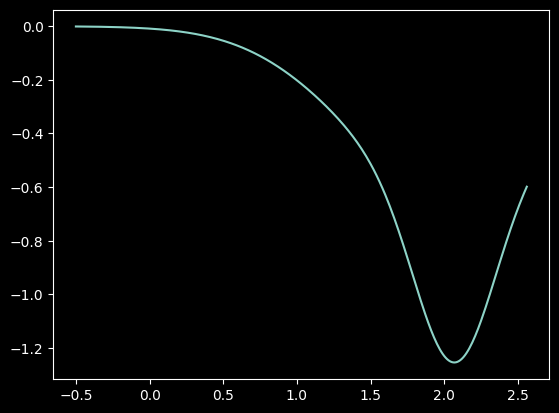

In [5]:
print(Vb.diagonal())


plt.plot(r,GL1.phi[:,80])

print([len(x.diagonal()) for x in Vs])
#plt.plot(Gb.phi[:,80])

In [122]:
M.basisSet.function_to_center(80)
print(M.geom[0])
print(M.geom[2])
print(np.argsort(np.abs(Gb.phi[:,80]))[-5:])

Dist    = np.array([np.linalg.norm(Gb.points[:,:3] - x,axis=1) for x in M.geom]).transpose()
print(Dist[np.argsort(np.abs(Gb.phi[:,80]))[-2:]])


Dist = np.array([np.linalg.norm(GL.points[:,:3] - x,axis=1) for x in M.geom]).transpose()
print(Dist[np.argsort(np.abs(GL.phi[:,80]))[-2:]])

print(L)



[-9.05435250e+00  1.24863465e+00  1.51178090e-05]
[-9.70774042 -0.17353166  1.35167763]
[645817 645818 645819 645812 645762]
[[2.06791842e+00 4.49839647e+00 7.20111513e-05 3.39826548e+00
  3.39829072e+00]
 [2.06793436e+00 4.49841157e+00 7.20111513e-05 3.39828379e+00
  3.39829555e+00]]
[[0.18       3.3420517  2.2479614  2.01200008 2.01198434]
 [0.17       3.34473625 2.2379614  2.01472825 2.01471287]]
[[-8.89637375e+00  1.59249172e+00 -3.26795266e-01]
 [-8.89953332e+00  1.58561458e+00 -3.20259058e-01]
 [-8.90269290e+00  1.57873744e+00 -3.13722850e-01]
 [-8.90585247e+00  1.57186030e+00 -3.07186643e-01]
 [-8.90901205e+00  1.56498316e+00 -3.00650435e-01]
 [-8.91217162e+00  1.55810601e+00 -2.94114227e-01]
 [-8.91533120e+00  1.55122887e+00 -2.87578020e-01]
 [-8.91849077e+00  1.54435173e+00 -2.81041812e-01]
 [-8.92165035e+00  1.53747459e+00 -2.74505604e-01]
 [-8.92480992e+00  1.53059745e+00 -2.67969397e-01]
 [-8.92796950e+00  1.52372031e+00 -2.61433189e-01]
 [-8.93112907e+00  1.51684316e+00 -2

In [82]:
M.geom

array([[-9.05435250e+00,  1.24863465e+00,  1.51178090e-05],
       [-5.65979400e+00,  1.24862898e+00, -1.13383568e-05],
       [-9.70774042e+00, -1.73531660e-01,  1.35167763e+00],
       [-9.70774231e+00,  7.89098607e-01, -1.90744231e+00],
       [-9.70776499e+00,  3.13029542e+00,  5.55759005e-01]])

   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 2   entry CL         line   534 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 


Basis is augmented!

Basis set has 116 functions
Creating a spherical grid for Index 2
   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 2   entry CL         line   534 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 


Basis is augmented!

Basis set has 92 functions
   => Loading Basis Set <=

    Name: DEF2-SVP
  

{'message': '   => Loading Basis Set <=\n\n    Name: DEF2-SVP\n    Role: ORBITAL\n    Keyword: BASIS\n    atoms 1   entry C          line    90 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs \n    atoms 2   entry CL         line   356 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs \n    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs \n\n',
 'key': 'BASIS',
 'name': 'DEF2-SVP',
 'blend': 'DEF2-SVP',
 'puream': 1,
 'shell_map': [['C1', '72db9a94c8f274aebf4410505c2208131fe6a66b'],
  ['CL2', '3639ab98fc0f5e64dafb43e8b43524c0e027c969'],
  ['H3',
   'a6d5fb68e49b46b6bbd6220d50dcb28b38bba2ff',
   [0, (1.0, -29.060718623314354), (7.421964784960768, -6.387511601999107)],
   [2,
    (1.24313207146987, -2.7009151831356557),
    (17.48402453637462, -0.8562872896920667),
    (33.99419901903818, -0.5050140864172199),
    (50.49808775204665, -0.37687125848323766),
    (66.99925349914432, -0.3285975470762305),
    (8

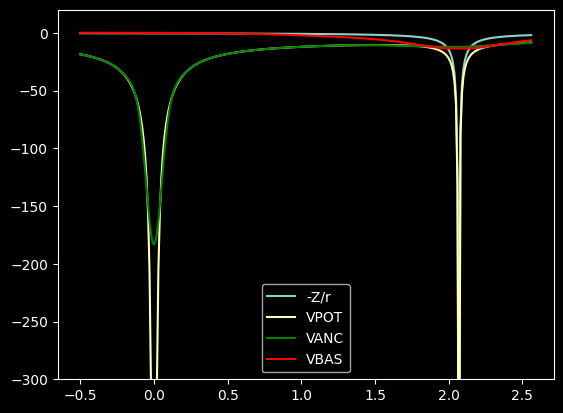

In [3]:
nSphere = 590
nRadial = 300
prec=2

Vs = [] 

atomIdx=2
M = myMolecule("tests/CH3Cl.xyz","def2-TZVP",labelAtoms=True)

M.keepAugmentBasisForIndex(atomIdx)

"""
a,newOrb = qcdb.BasisSet.pyconstruct(M.psi4Mol.to_dict(),'BASIS',
                                            "def2-TZVP",fitrole='ORBITAL',
                                            other=None,return_dict=True,return_atomlist=False)
for i in newOrb["shell_map"]:
            del i[2:]

for c,i in enumerate(M.getOrbitalDict()["shell_map"]):
    if c == atomIdx:
        newOrb["shell_map"][c] += i[2:]
"""

M.setBasisDict(orbitalDict=None,augmentDict=M.getAugmentDict())


Gb =  sphericalIndexGrid(M,atomIdx,minDist=0.0,maxDist=1.5,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
Vb = Gb.optimizeBasis(potentialType="anc",a=2)

P1 = M.geom[0]
P2 = M.geom[2]

v = P2-P1
r = np.arange(-0.5,np.linalg.norm(v)+0.5,0.01)

L = np.array([P1 + i*v/np.linalg.norm(v) for i in r])
VPOT = vpot(Gb.mol.geom,Gb.mol.elez,L)
VANC = vpotANC(Gb.mol.geom,Gb.mol.elez,L,prec)
GL2 = pointGrid(M,L)
VBAS = vBpot(GL2.phi,Vb.diagonal())


plt.plot(r,vpot([M.geom[atomIdx]],[M.elez[atomIdx]],L),label="-Z/r")

plt.plot(r,VPOT,label="VPOT")
plt.plot(r,VANC,label="VANC",color="green")
plt.plot(r,VBAS,label="VBAS",color="red")
plt.legend()
plt.ylim(-300,20)
M.getAugmentDict()

In [107]:
Vb.diagonal()

array([-8.83696302e+00,  5.43330941e-04, -3.13829165e-03,  5.17213445e-04,
       -2.33507769e-03,  1.98081608e-03])

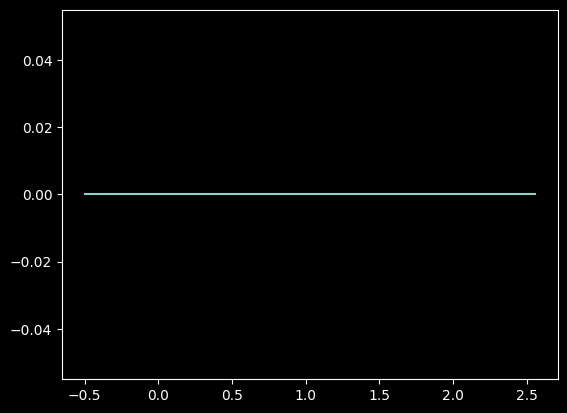

In [30]:
M.basisSet.function_to_center(68)
plt.plot(r,GL2.phi[:,70])



In [33]:
M.basisSet.function_to_center(0)
print(M.geom[0])
print(M.geom[2])
print(np.argsort(np.abs(Gb.phi[:,0]))[-5:])

Dist    = np.array([np.linalg.norm(Gb.points[:,:3] - x,axis=1) for x in M.geom]).transpose()
print(Dist[np.argsort(np.abs(Gb.phi[:,68]))[-2:]])


Dist = np.array([np.linalg.norm(GL2.points[:,:3] - x,axis=1) for x in M.geom]).transpose()
print(Dist[np.argsort(np.abs(GL2.phi[:,68]))[-2:]])

print(Dist)



[-9.05435250e+00  1.24863465e+00  1.51178090e-05]
[-9.70774042 -0.17353166  1.35167763]
[643406 643202 643201 643219 643203]
[[2.06798428e+00 4.49844190e+00 7.20111513e-05 3.39833419e+00
  3.39833064e+00]
 [2.06793436e+00 4.49841157e+00 7.20111513e-05 3.39828379e+00
  3.39829555e+00]]
[[0.46       3.27839622 2.5279614  1.9549289  1.95490304]
 [0.45       3.28027937 2.5179614  1.95630586 1.95628036]]
[[0.5        3.27115848 2.5679614  1.94992423 1.94989692]
 [0.49       3.27292358 2.5579614  1.95109973 1.95107278]
 [0.48       3.27471828 2.5479614  1.95232573 1.95229915]
 ...
 [2.54       4.83974995 0.4720386  3.7957124  3.79575241]
 [2.55       4.84721885 0.4820386  3.80431574 3.80435583]
 [2.56       4.85469685 0.4920386  3.81292589 3.81296607]]


# Absolute very new approach

## Step 1 optimize just with the augmented basis set

Basis string is empty
   => Loading Basis Set <=

    Name: DEF2-SVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line    90 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs 
    atoms 2   entry CL         line   356 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs 
    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs 


Basis set only augmented!!

Basis set has 30 functions
Basis string is empty
   => Loading Basis Set <=

    Name: DEF2-SVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line    90 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs 
    atoms 2   entry CL         line   356 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs 
    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs 


Basis set only augmented!!

Basis set has 30 functions
Creating a spherical grid for Index 0


(-300.0, 20.0)

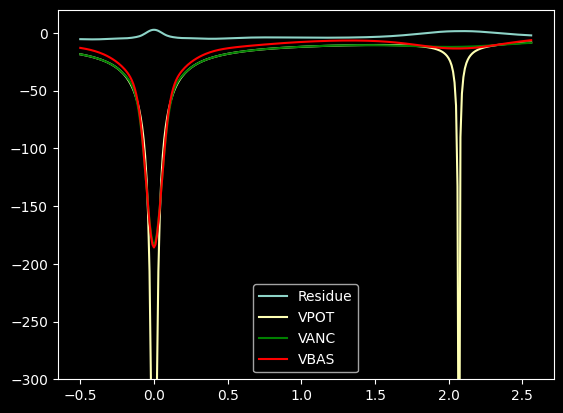

In [161]:
nSphere = 590
nRadial = 300
prec=2

Va = [] 
M = myMolecule("tests/CH3Cl.xyz","",labelAtoms=True)
for atomIdx in range(len(M.geom)):
    M = myMolecule("tests/CH3Cl.xyz","",labelAtoms=True)
    M.keepAugmentBasisForIndex(atomIdx)
    M.setBasisDict(orbitalDict=None,augmentDict=M.getAugmentDict(),quiet=True)
    
    Ga =  sphericalIndexGrid(M,atomIdx,minDist=0.0,maxDist=1.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
    Va.append(Ga.optimizeBasis(potentialType="anc",a=2))

M = myMolecule("tests/CH3Cl.xyz","",labelAtoms=True)
Gb =  sphericalGrid(M,minDist=0.0,maxDist=4.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
Vb = Gb.optimizeBasis(potentialType="anc",a=2)

for c,i in enumerate(Vb.diagonal()):
    Vb[c][c] = 0.0 
  
counter = 0
for c2,j in enumerate(Va):
    for c,i in enumerate(j.diagonal()):
        if c2 in [0,1,2,3,4]:
            Vb[counter][counter] = i
        counter+=1
        
P1 = M.geom[0]
P2 = M.geom[2]

v = P2-P1
r = np.arange(-0.5,np.linalg.norm(v)+0.5,0.01)

L = np.array([P1 + i*v/np.linalg.norm(v) for i in r])

VPOT = vpot(Gb.mol.geom,Gb.mol.elez,L)
VANC = vpotANC(Gb.mol.geom,Gb.mol.elez,L,prec)
GL2 = pointGrid(M,L)
VBAS = vBpot(GL2.phi,Vb.diagonal())

R = VANC - VBAS


plt.plot(r,R,label="Residue")

plt.plot(r,VPOT,label="VPOT")
plt.plot(r,VANC,label="VANC",color="green")
plt.plot(r,VBAS,label="VBAS",color="red")
plt.legend()
plt.ylim(-300,20)



   => Loading Basis Set <=

    Name: AUG-CC-PV5Z
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   387 file /media/miniconda3/envs/vpot/share/psi4/basis/aug-cc-pv5z.gbs 
    atoms 2   entry CL         line  1533 file /media/miniconda3/envs/vpot/share/psi4/basis/aug-cc-pv5z.gbs 
    atoms 3-5 entry H          line    42 file /media/miniconda3/envs/vpot/share/psi4/basis/aug-cc-pv5z.gbs 


Basis set not augmented!! 

Basis set has 498 functions
Filter: (646234, 4)


   => Loading Basis Set <=

    Name: DEF2-QZVPP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   194 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-qzvpp.gbs 
    atoms 2   entry CL         line   817 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-qzvpp.gbs 
    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-qzvpp.gbs 


Basis set not augmented!! 

Basis set has 217 functions
Filter: (646234, 4)
GridInfo : {'type': 'spherical', 'minDist': 0.0, 'maxDist': 4.0, 'nRadical': 300, 'nSphere': 590, 'nPoints': 646234, 'radialScheme': 'BECKE', 'pruningScheme': 'None'} 
residue  : 1728959.047931152
MeanError: 2.675438073408629
MaxError : 74.6752881717685
MinError : 1.7527580386268838e-13


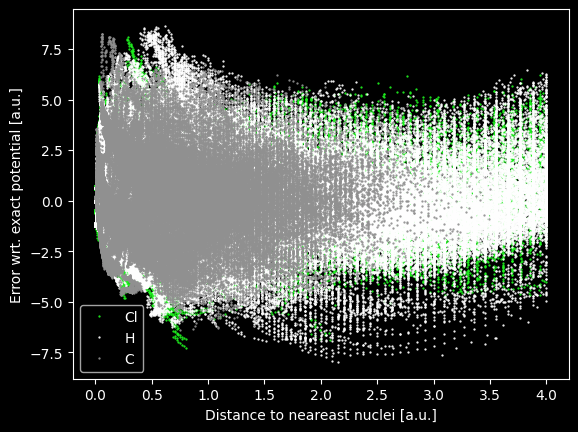

(-200.0, 40.0)

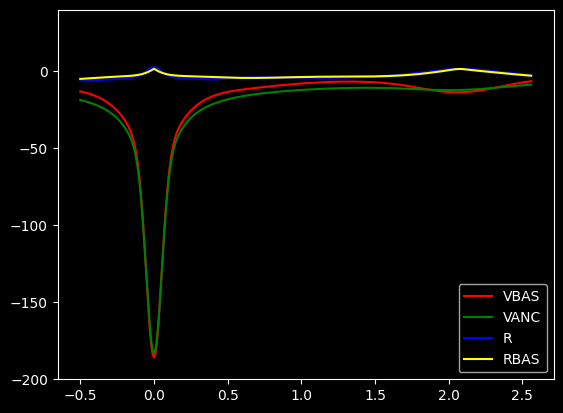

In [143]:
Ma = myMolecule("tests/CH3Cl.xyz","def2-QZVPP",augmentBasis=False,labelAtoms=True)
Gbb = sphericalGrid(Ma,minDist=0.0,maxDist=4.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
VANC = vpotANC(Gb.mol.geom,Gb.mol.elez,Gb.points,prec)
VBAS = vBpot(Gb.phi,Vb.diagonal())
Ra = VANC - VBAS

Vbb= Gbb.optimizeBasis(potentialType=Ra)
Gbb.printStats(Vbb,output="print")
Gbb.exportErrorVsDistance(Vbb)

P1 = Ma.geom[0]
P2 = Ma.geom[2]

v = P2-P1
r = np.arange(-0.5,np.linalg.norm(v)+0.5,0.01)

L = np.array([P1 + i*v/np.linalg.norm(v) for i in r])

VANC = vpotANC(Gbb.mol.geom,Gbb.mol.elez,L,prec)
GL2 = pointGrid(M,L)
GL3 = pointGrid(Ma,L)

VBAS = vBpot(GL2.phi,Vb.diagonal())
R = VANC - VBAS


RBAS = vBpot(GL3.phi,Vbb.diagonal())


plt.plot(r,VBAS,label="VBAS",color="red")
plt.plot(r,VANC,label="VANC",color="green")
plt.plot(r,R,label="R",color="blue")
plt.plot(r,RBAS,label="RBAS",color="yellow")


plt.legend()
plt.ylim((-200,40))


   => Loading Basis Set <=

    Name: AUG-CC-PV5Z
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   387 file /media/miniconda3/envs/vpot/share/psi4/basis/aug-cc-pv5z.gbs 
    atoms 2   entry CL         line  1533 file /media/miniconda3/envs/vpot/share/psi4/basis/aug-cc-pv5z.gbs 
    atoms 3-5 entry H          line    42 file /media/miniconda3/envs/vpot/share/psi4/basis/aug-cc-pv5z.gbs 


Basis is augmented!

Basis set has 528 functions
Filter: (646234, 4)


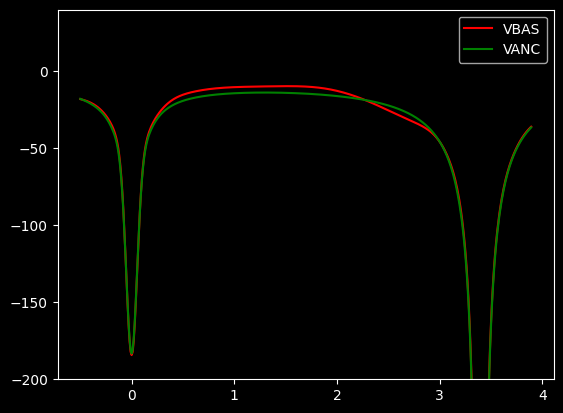

GridInfo : {'type': 'spherical', 'minDist': 0.0, 'maxDist': 4.0, 'nRadical': 300, 'nSphere': 590, 'nPoints': 646234, 'radialScheme': 'BECKE', 'pruningScheme': 'None'} 
residue  : 1683998.84527888
MeanError: 2.6058654377189687
MaxError : 57.93823580197402
MinError : 9.740574398507051e-12


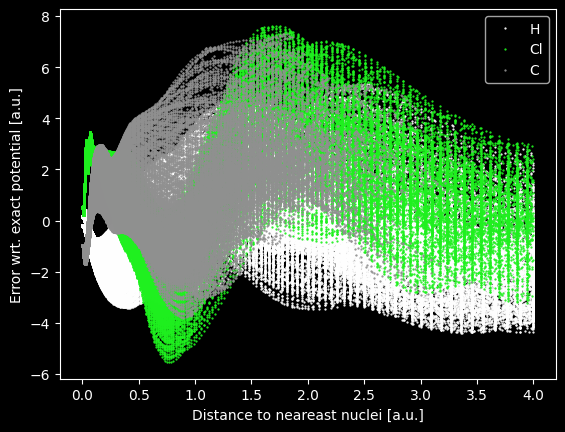

In [139]:
Mt = myMolecule("tests/CH3Cl.xyz","aug-cc-pV5Z",augmentBasis=True,labelAtoms=True)
Gt = sphericalGrid(Mt,minDist=0.0,maxDist=4.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
Vt = Gt.optimizeBasis(potentialType="anc",a=2)


V = [] 
for c,i in enumerate(Ma.geom):
    Vl = []
    for c2,j in enumerate(Vbb.diagonal()):
        if Ma.basisSet.function_to_center(c2) == c:
            Vl.append(j)
    V.append(Vl)




for c,i in enumerate(Vt.diagonal()):
    Vt[c][c] = 0.0 
    
counter = 0
for c,i in enumerate(Mt.geom):
    for j in Va[c].diagonal():
        Vt[counter][counter] = j
        counter +=1
    for j in V[c]:
        Vt[counter][counter] = j 
        counter +=1
        
P1 = Ma.geom[0]
P2 = Ma.geom[1]

v = P2-P1
r = np.arange(-0.5,np.linalg.norm(v)+0.5,0.01)

L = np.array([P1 + i*v/np.linalg.norm(v) for i in r])

GLt = pointGrid(Mt,L)
VBAS = vBpot(GLt.phi,Vt.diagonal())
VANC = vpotANC(GLt.mol.geom,Gt.mol.elez,L,prec)

plt.plot(r,VBAS,label="VBAS",color="red")
plt.plot(r,VANC,label="VANC",color="green")



plt.legend()
plt.ylim((-200,40))
plt.show()


Gt.printStats(Vt,output="print")
Gt.exportErrorVsDistance(Vt)


In [126]:
plt.imshow

array([-2.51595555e+01,  0.00000000e+00, -3.61917192e-35,  1.15083183e-35,
        0.00000000e+00, -2.25486330e-30, -5.45660859e-01, -8.01437826e-01,
       -8.79544582e-01, -6.29126392e-01, -3.84041592e-01, -2.95772815e-22,
        1.10982201e-16,  1.28817430e-16, -5.31378465e-23,  4.98751922e-18,
       -6.31627540e-18,  1.43488216e-23, -1.33974390e-18,  1.71962432e-18,
        0.00000000e+00,  1.76485488e-36, -2.32733163e-37,  0.00000000e+00,
        1.15661529e-31,  0.00000000e+00,  8.55894438e-43,  0.00000000e+00,
        0.00000000e+00, -4.44860308e-37,  0.00000000e+00, -2.40741243e-35,
       -2.46519033e-32,  0.00000000e+00,  6.02255841e-57,  3.61111865e-35,
        9.86076132e-32,  2.35192394e-03, -2.55054655e-04, -6.88600736e-09,
        1.15001712e-14,  4.41767621e-04, -1.47557301e-09, -1.57116964e-06,
        1.94741315e-05, -2.08814834e-04, -1.71883883e-02, -9.50823754e-02,
       -2.14701878e-10,  2.75481373e-05, -4.60075453e-11, -3.00745867e-09,
        3.85883371e-04, -

In [96]:
#for c,i in enumerate(Vbb.diagonal()):
#    print(Ma.basisSet.function_to_center(c))
    
V = [] 
for c,i in enumerate(Ma.geom):
    Vl = []
    for c2,j in enumerate(Vbb.diagonal()):
        if Ma.basisSet.function_to_center(c2) == c:
            Vl.append(j)
    V.append(Vl)

In [106]:
V[0][5], Vbb.diagonal()[5]

(-0.9670713804032829, -0.9670713804032829)

Basis string is empty
Basis string is empty
Creating a spherical grid for Index 0
Basis string is empty
Creating a spherical grid for Index 1
Basis string is empty
Creating a spherical grid for Index 2
Basis string is empty
Creating a spherical grid for Index 3
Basis string is empty
Creating a spherical grid for Index 4
Basis string is empty
Creating a spherical grid for Index 5
Basis string is empty
Creating a spherical grid for Index 6
Basis string is empty
Creating a spherical grid for Index 7
Basis string is empty
Filter: (1068698, 4)
Filter: (1068698, 4)
Filter: (1068698, 4)
Basis string is empty
Filter: (1068698, 4)
Filter: (1068698, 4)
GridInfo : {'type': 'spherical', 'minDist': 0.0, 'maxDist': 4.0, 'nRadical': 300, 'nSphere': 590, 'nPoints': 1068698, 'radialScheme': 'BECKE', 'pruningScheme': 'None'} 
residue  : 1750826.8425906564
MeanError: 1.6382802649491777
MaxError : 30.853306114946708
MinError : 2.224849867511114e-13


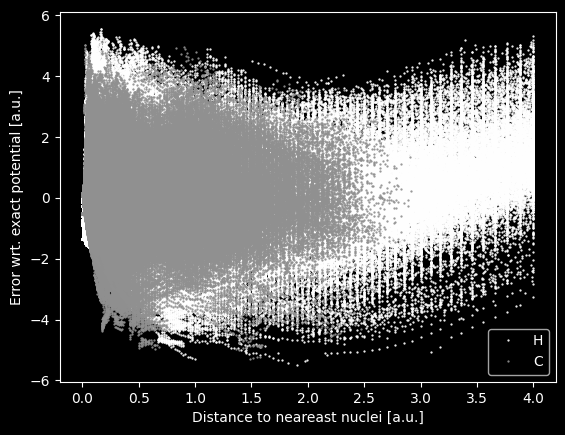

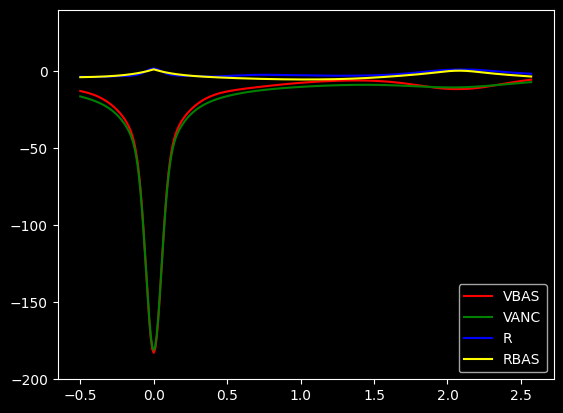

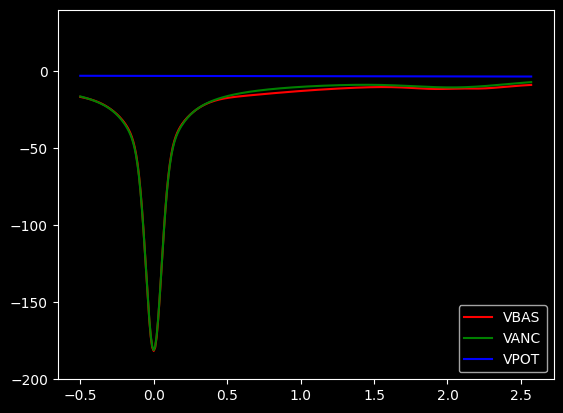

In [222]:
class Optimizer(object):
    
    def unwrapMatrix(self, M):
        dim = sum([len(x) for x in M])
        
        newMat = np.zeros((dim,dim))
        
        counter = 0
        for j in M:
            for i in j.diagonal():
                newMat[counter][counter] = i
                counter+=1
                
        return newMat
        
    
    def plotAugmentBasis(self,idx1=0,idx2=1):
        M = myMolecule(self.pathToMolecule,"",labelAtoms=True)
        Gb =  sphericalGrid(M,minDist=0.0,maxDist=4.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
        Vb = Gb.optimizeBasis(potentialType="anc",a=2)
        
        for c,i in enumerate(Vb.diagonal()):
            Vb[c][c] = 0.0 
  
        counter = 0
        for c2,j in enumerate(self.Va):
            for i in j.diagonal():
                Vb[counter][counter] = i
                counter+=1

        Gb.printStats(Vb,output="print")
        Gb.exportErrorVsDistance(Vb)

        P1 = M.geom[idx1]
        P2 = M.geom[idx2]

        v = P2-P1
        r = np.arange(-0.5,np.linalg.norm(v)+0.5,0.01)

        L = np.array([P1 + i*v/np.linalg.norm(v) for i in r])

        VPOT = vpot(Gb.mol.geom,Gb.mol.elez,L)
        VANC = vpotANC(Gb.mol.geom,Gb.mol.elez,L,self.prec)
        GL2 = pointGrid(M,L)
        VBAS = vBpot(GL2.phi,Vb.diagonal())

        R = VANC - VBAS

        plt.plot(r,R,label="Residue")
        plt.plot(r,VPOT,label="VPOT")
        plt.plot(r,VANC,label="VANC",color="green")
        plt.plot(r,VBAS,label="VBAS",color="red")
        plt.legend()
        plt.ylim(-300,20)


        
    
    def optimizeAugmentBasis(self):
        Va = [] 
        M = myMolecule(self.pathToMolecule,"",labelAtoms=True)
        
        for atomIdx in range(len(M.geom)):
            M = myMolecule(self.pathToMolecule,"",labelAtoms=True)
            M.keepAugmentBasisForIndex(atomIdx)
            M.setBasisDict(orbitalDict=None,augmentDict=M.getAugmentDict(),quiet=True)

            Ga =  sphericalIndexGrid(M,atomIdx,minDist=0.0,maxDist=1.0,nSphere=self.nSphere,nRadial=self.nRadial,pruningScheme="None") 
            Va.append(Ga.optimizeBasis(potentialType="anc",a=2))

        self.Va = Va
        return Va
    
    def plotOrbitalBasis(self,idx1=0,idx2=1):
        Ma = myMolecule(self.pathToMolecule,"",augmentBasis=True,labelAtoms=True)
        Mo = myMolecule(self.pathToMolecule,self.orbitalBasisSet,augmentBasis=False,labelAtoms=True)
        
        Ga = sphericalGrid(Ma,minDist=0.0,maxDist=4.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
        Go = sphericalGrid(Mo,minDist=0.0,maxDist=4.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
        
        VANC = vpotANC(Ga.mol.geom,Ga.mol.elez,Ga.points,self.prec)
        VBAS = vBpot(Ga.phi,self.unwrapMatrix(self.Va).diagonal())
        Ra = VANC - VBAS

        Vo = Go.optimizeBasis(potentialType=Ra)
        Go.printStats(Vo,output="print")
        Go.exportErrorVsDistance(Vo)

        P1 = Ma.geom[idx1]
        P2 = Ma.geom[idx2]

        v = P2-P1
        r = np.arange(-0.5,np.linalg.norm(v)+0.5,0.01)

        L = np.array([P1 + i*v/np.linalg.norm(v) for i in r])

        VANC = vpotANC(Ga.mol.geom,Ga.mol.elez,L,self.prec)
        GL2 = pointGrid(Ma,L)
        GL3 = pointGrid(Mo,L)

        VBAS = vBpot(GL2.phi,self.unwrapMatrix(self.Va).diagonal())
        RBAS = vBpot(GL3.phi,Vo.diagonal())
        R = VANC - VBAS



        plt.plot(r,VBAS,label="VBAS",color="red")
        plt.plot(r,VANC,label="VANC",color="green")
        plt.plot(r,R,label="R",color="blue")
        plt.plot(r,RBAS,label="RBAS",color="yellow")


        plt.legend()
        plt.ylim((-200,40))
        plt.show()

    
    def optimizeOrbitalBasis(self):
        Ma   = myMolecule(self.pathToMolecule,self.orbitalBasisSet,augmentBasis=False,labelAtoms=True)
        Gbb  = sphericalGrid(Ma,minDist=0.0,maxDist=4.0,nSphere=self.nSphere,nRadial=self.nRadial,pruningScheme="None") 
        

        Vbb= Gbb.optimizeBasis(potentialType=self.residue)
        
        
        V = [] 
        for c,i in enumerate(Ma.geom):
            Vl = []
            for c2,j in enumerate(Vbb.diagonal()):
                if Ma.basisSet.function_to_center(c2) == c:
                    Vl.append(j)
            V.append(Vl)
            
            
        self.Vo = V
            
        return V
        
    def plotTotalBasis(self,idx1=0,idx2=1):
        Mt = myMolecule(self.pathToMolecule,self.orbitalBasisSet,augmentBasis=True,labelAtoms=True)

        
        P1 = Mt.geom[idx1]
        P2 = Mt.geom[idx2]

        v = P2-P1
        r = np.arange(-0.5,np.linalg.norm(v)+0.5,0.01)

        L = np.array([P1 + i*v/np.linalg.norm(v) for i in r])

        GLt = pointGrid(Mt,L)
        VBAS = vBpot(GLt.phi,self.Vt.diagonal())
        VANC = vpotANC(GLt.mol.geom,GLt.mol.elez,L,self.prec)
        VPOT = vpot(Gb.mol.geom,Gb.mol.elez,L)

        plt.plot(r,VBAS,label="VBAS",color="red")
        plt.plot(r,VANC,label="VANC",color="green")
        plt.plot(r,VPOT,label="VPOT",color="blue")




        plt.legend()
        plt.ylim((-200,40))
        plt.show()
        
    def optimizeTotalBasis(self):
        Mt = myMolecule(self.pathToMolecule,self.orbitalBasisSet,augmentBasis=True,labelAtoms=True)
        Gt = sphericalGrid(Mt,minDist=0.0,maxDist=4.0,nSphere=self.nSphere,nRadial=self.nRadial,pruningScheme="None") 
        Vt = Gt.optimizeBasis(potentialType="anc",a=2)
        
        for c,i in enumerate(Vt.diagonal()):
            Vt[c][c] = 0.0 

        counter = 0
        for c,i in enumerate(Mt.geom):
            for j in self.Va[c].diagonal():
                Vt[counter][counter] = j
                counter +=1
            for j in self.Vo[c]:
                Vt[counter][counter] = j 
                counter +=1
                
        self.Vt = Vt

       
        
        
        
    
    def calculateResidue(self,Va):
        M  = myMolecule(self.pathToMolecule,"",labelAtoms=True)
        Gb =  sphericalGrid(M,minDist=0.0,maxDist=4.0,nSphere=nSphere,nRadial=nRadial,pruningScheme="None") 
        
        
        VANC = vpotANC(Gb.mol.geom,Gb.mol.elez,Gb.points,self.prec)
        VBAS = vBpot(Gb.phi,self.unwrapMatrix(self.Va).diagonal())
        Ra = VANC - VBAS
                
        self.residue = Ra
        
        return R
    
    def __init__(self,pathToMolecule,orbitalBasisSet):
        
        #Start with the augmented basis optimization:
        self.nSphere = 590
        self.nRadial = 300
        self.prec=2
        
        self.pathToMolecule = pathToMolecule
        self.orbitalBasisSet = orbitalBasisSet
        self.residue = None
        
        self.Va = None
        self.Vo = None
        self.Vt = None
        
        self.optimizeAugmentBasis()
        self.calculateResidue(self.Va)
        self.optimizeOrbitalBasis()
        self.optimizeTotalBasis()

        
        
        
        
opti = Optimizer("tests/C2H6.xyz","def2-TZVP")      
opti.plotOrbitalBasis(0,2)
opti.plotTotalBasis(0,2)
        
        

In [213]:
opti.unwrapMatrix(opti.Va).diagonal()

array([-2.51595555e+01,  5.24110749e-04, -4.90268448e-04,  7.84495595e-05,
       -1.11642016e-03,  2.41438953e-04, -6.65709090e+01,  1.26126105e-04,
        1.21969725e-06,  5.33817423e-08, -2.23556883e-04,  7.90357194e-07,
       -1.06749864e+01, -1.32553344e-03,  5.22603867e-03,  1.00992357e-02,
        2.73804093e-03, -5.76086247e-03, -1.06776115e+01, -8.53946608e-03,
       -8.58819150e-03, -4.85312970e-03, -2.73289284e-03, -2.58694082e-03,
       -1.06755311e+01,  5.58720091e-03,  2.87287300e-03, -5.42919149e-03,
        6.32440482e-03,  7.85553561e-03])

In [187]:
sum([len(x) for x in Va])

30